# Import WTG layouts

#### Welcome to this Jupiter Notebook!

This Jupyter Notebook facilitates the creation of a new WTG layout within your WTG.gdb. It helps add coordinates, metadata, alias names, and enables file exports in SHP and DWG formats, culminating in zipping the final output.

 The workflow unfolds as follows:

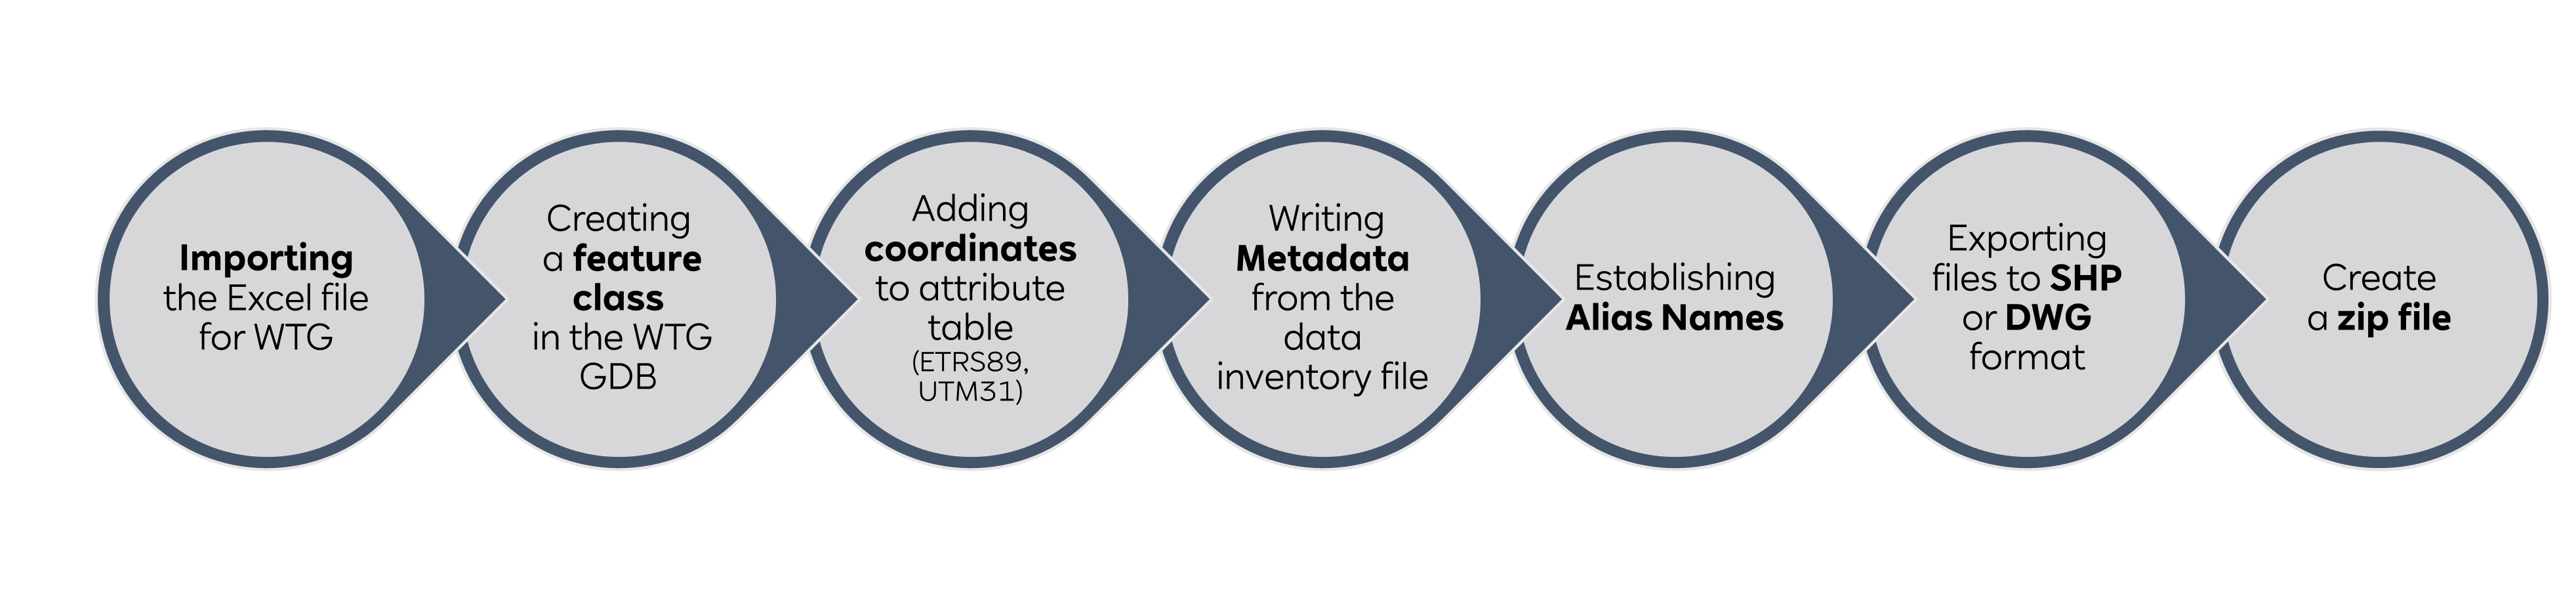

##### Import various libraries and modules for geospatial data 

In [56]:
import os
import arcpy
import zipfile
import pandas as pd
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
from arcpy import metadata as md

####  1)  You need to insert your input parameters

- Excel file path for **WTG layout**

- Path to the **output GDB**

- Path to the **Data inventory**
⚠️ Prior to execution, ensure all necessary information is filled in the **Data inventory file**.

- **Output Feature Class Name** should be the same as registered Name in the data inventory 

- **Defined Spatial Reference**: Specification of the spatial reference system to be applied.

In [57]:
# Excel File Containing WTG layout from RA
file_path =  r"\\WM20ocqu46ph01\TEMP\Andrea_Sulova\Python\JupiterNotebook_Magic\Layouts\IJVER15MW-21MW-18MWBC2.xlsx"

sheet_name = 'Site layouts SG236-15MW'

# Output Feature Class Name
output_fc = "NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete" 

# Path to the WTG GDB 
output_gdb = r"\\WM20ocqu46ph01\WF_Projects\NL_IJV\2_FINAL\WTG\WTG.gdb"

# Path to the Data Inventory
data_inventory = r"\\WM20ocqu46ph01\WF_Projects\NL_IJV\5_PROJECTDOCS\NL_IJV_Dataset_Inventory.xlsx"

# Defined Spatial Reference
spatial_reference = arcpy.SpatialReference(25831) 

###   2) Import excel files to Dataframe

Read the Excel file into a Pandas DataFrame starting from row 2

In [58]:
df = pd.read_excel(file_path, sheet_name = sheet_name,  skiprows = 1)
print(df.columns)
df.head(8)


Index(['Unnamed: 0', 'ID', 'Easting ', 'Northing ', 'Unnamed: 4', 'ID.1',
       'Easting .1', 'Northing .1', 'Unnamed: 8', 'ID.2', 'Easting .2',
       'Northing .2', 'Unnamed: 12', 'ID.3', 'Easting .3', 'Northing .3',
       'Unnamed: 16', 'Unnamed: 17',
       '2*67*SG236-15MW-159mHH (ALPHA)\n2*67*SG236-15MW-144mHH (BETA)'],
      dtype='object')


,Unnamed: 0,ID,Easting,Northing,Unnamed: 4,ID.1,Easting .1,Northing .1,Unnamed: 8,ID.2,Easting .2,Northing .2,Unnamed: 12,ID.3,Easting .3,Northing .3,Unnamed: 16,Unnamed: 17,2*67*SG236-15MW-159mHH (ALPHA)\n2*67*SG236-15MW-144mHH (BETA)
0,NaN,Site-I_01,540024.0,5850496.0,NaN,Site-II_01,528902.9,5862281.1,NaN,Site-III_01,537909.900000,5.858423e+06,NaN,Site-IV_01,530022.1,5865639.7,NaN,NaN,NaN
1,NaN,Site-I_02,532082.0,5849646.0,NaN,Site-II_02,524026.4,5849858.4,NaN,Site-III_02,544341.600000,5.860925e+06,NaN,Site-IV_02,534180.0,5870501.7,NaN,NaN,NaN
2,NaN,Site-I_03,536206.0,5854318.0,NaN,Site-II_03,530010.6,5850110.9,NaN,Site-III_03,537957.400000,5.856981e+06,NaN,Site-IV_03,531543.3,5865798.0,NaN,NaN,NaN
3,NaN,Site-I_04,532624.0,5848010.0,NaN,Site-II_04,528524.3,5861219.4,NaN,Site-III_04,539361.300000,5.857673e+06,NaN,Site-IV_04,532048.3,5871729.4,NaN,NaN,NaN
4,NaN,Site-I_05,535087.0,5849426.0,NaN,Site-II_05,528966.1,5860395.9,NaN,Site-III_05,539343.800000,5.856231e+06,NaN,Site-IV_05,532671.3,5865198.2,NaN,NaN,NaN
5,NaN,Site-I_06,531683.0,5846858.0,NaN,Site-II_06,529925.9,5861445.6,NaN,Site-III_06,540335.225949,5.862556e+06,NaN,Site-IV_06,529651.4,5864574.6,NaN,NaN,NaN
6,NaN,Site-I_07,536883.0,5849292.0,NaN,Site-II_07,532638.4,5859225.6,NaN,Site-III_07,543092.200000,5.865270e+06,NaN,Site-IV_07,532614.2,5870281.7,NaN,NaN,NaN
7,NaN,Site-I_08,537012.0,5850585.0,NaN,Site-II_08,531588.6,5858498.3,NaN,Site-III_08,542964.400000,5.863096e+06,NaN,Site-IV_08,531413.7,5869835.8,NaN,NaN,NaN


- Column names from the Excel file representing ID, Easting, and Northing

###   2) Creating a wtg laytout feature class in the WTG.gdb
Column names from the Excel file representing ID, Easting, and Northing

In [59]:
ID_Column = "ID"         # Column for ID
X_Column  = "Easting .1"    # Column for Easting (X-coordinate)
Y_Column  = "Northing .1"   # Column for Northing (Y-coordinate)

In [60]:
# Create a new feature class in the geodatabase
fc_path = os.path.join(output_gdb, output_fc)

# Delete the feature class if it exists
arcpy.management.Delete(fc_path)


# Check if the feature class doesn't exist and create it
if not arcpy.Exists(fc_path):
    arcpy.CreateFeatureclass_management(output_gdb, output_fc, "POINT", spatial_reference='25831')
    print("Feature class created.")
    
    # Define fields from Excel columns and their data types

    field_mappings = [("ID", "TEXT"), ("Point_X", "DOUBLE"), ("Point_Y", "DOUBLE")]

    # Add fields to the feature class
    for field_name, data_type in field_mappings:
        arcpy.management.AddField(fc_path, field_name, data_type)

    # Iterate through Excel data and insert rows into the feature class
    with arcpy.da.InsertCursor(fc_path, ["SHAPE@", "ID", "Point_X", "Point_Y"]) as cursor:
        for index, row in df.iterrows():
            # Get X and Y coordinates from Excel (assuming columns "Longitude" and "Latitude")
            x, y, id = row[X_Column], row[Y_Column], row[ID_Column]
            # Create a point geometry
            point = arcpy.Point(x, y)
            # Create a new row with point geometry and other attributes
            cursor.insertRow([arcpy.PointGeometry(point, spatial_reference), str(row[ID_Column]), str(row[X_Column]), float(row[Y_Column])])

    print("Feature class created successfully.")
   

Feature class created.
Feature class created successfully.


- Show positions of WTGs on the map

In [61]:
# Establish a connection to your GIS (provide credentials if necessary)
gis = GIS()

# Load the map
map = gis.map("Netherlands")  # Replace 'Your_Location' with your desired location
my_fc = pd.DataFrame.spatial.from_featureclass(fc_path)
map = my_fc.spatial.plot()
map


MapView(layout=Layout(height='400px', width='100%'))

### 3) Adding  coordinates to attribute table (ETRS89, UTM31 )

In [62]:
# Delete the fields and Set the field names to delete
del_fields = ["X_ETRS_UTM31", "Y_ETRS_UTM31","X_ETRS", "Y_ETRS", 'POINT_X', 'POINT_Y']

arcpy.DeleteField_management(fc_path, del_fields)

# Create a search cursor to fetch data from the feature class
fields = [field.name for field in arcpy.ListFields(fc_path)]

arcpy.DeleteField_management(fc_path, del_fields)

# Create a search cursor to fetch data from the feature class
fields = [field.name for field in arcpy.ListFields(fc_path)]

out_sr = arcpy.SpatialReference(25831) # ETRS 1989 UTM Zone 31N - 25831 

# Add geometry attributes
geom_props = "POINT_X_Y_Z_M"
arcpy.AddGeometryAttributes_management(fc_path, geom_props , "", "", out_sr)



# Rename the fields POINT_X and POINT_Y to X_COORD and Y_COORD
arcpy.AlterField_management(fc_path, "POINT_X", "X_ETRS_UTM31", "Easting [ETRS 1989 UTM31] ")
arcpy.AlterField_management(fc_path, "POINT_Y", "Y_ETRS_UTM31", "Northing [ETRS 1989 UTM31]")


# Create an update cursor to access the rows of the feature class
with arcpy.da.UpdateCursor(fc_path, ["X_ETRS_UTM31", "Y_ETRS_UTM31"]) as cursor:
    # Loop through each row
    for row in cursor:
        # Round the coordinates to 1 decimal place using numpy.round
        row[0] = numpy.round(row[0], 0)
        row[1] = numpy.round(row[1], 0)
        # Update the row with the rounded values
        cursor.updateRow(row)


# ETRS1989 - 4258
# Set the output coordinate system
out_sr = arcpy.SpatialReference(4258) 
geom_props = "POINT_X_Y_Z_M"
arcpy.AddGeometryAttributes_management(fc_path, geom_props , "", "", out_sr)


# Rename the fields POINT_X and POINT_Y to X_COORD and Y_COORD
arcpy.AlterField_management(fc_path, "POINT_X", "X_ETRS", "X [ETRS 1989]")
arcpy.AlterField_management(fc_path, "POINT_Y", "Y_ETRS", "Y [ETRS 1989]")

# Create a search cursor to fetch data from the feature class
fields = [field.name for field in arcpy.ListFields(fc_path)]
print('Adding coordinates to attribute table:',fields)

fc = pd.DataFrame.spatial.from_featureclass(fc_path)
fc

Adding coordinates to attribute table: ['OBJECTID', 'Shape', 'ID', 'X_ETRS_UTM31', 'Y_ETRS_UTM31', 'X_ETRS', 'Y_ETRS']


,OBJECTID,ID,X_ETRS_UTM31,Y_ETRS_UTM31,X_ETRS,Y_ETRS,SHAPE
0,1,Site-I_01,528903.0,5862281.0,3.429779,52.909423,"{""x"": 528902.9000000004, ""y"": 5862281.1, ""spat..."
1,2,Site-I_02,524026.0,5849858.0,3.356353,52.797989,"{""x"": 524026.4000000004, ""y"": 5849858.4, ""spat..."
2,3,Site-I_03,530011.0,5850111.0,3.445129,52.799959,"{""x"": 530010.5999999996, ""y"": 5850110.9, ""spat..."
3,4,Site-I_04,528524.0,5861219.0,3.424057,52.899899,"{""x"": 528524.2999999998, ""y"": 5861219.4, ""spat..."
4,5,Site-I_05,528966.0,5860396.0,3.430551,52.892473,"{""x"": 528966.0999999996, ""y"": 5860395.9, ""spat..."
...,...,...,...,...,...,...,...
62,63,Site-I_63,531972.0,5854218.0,3.474617,52.836770,"{""x"": 531971.5999999996, ""y"": 5854218.30000000..."
63,64,Site-I_64,524768.0,5849056.0,3.367284,52.790744,"{""x"": 524767.5, ""y"": 5849056.199999999, ""spati..."
64,65,Site-I_65,530190.0,5857695.0,3.448496,52.868126,"{""x"": 530190.2999999998, ""y"": 5857695, ""spatia..."
65,66,Site-I_66,529316.0,5859467.0,3.435662,52.884106,"{""x"": 529315.5999999996, ""y"": 5859467.30000000..."


### 4) Metadata extracted from IJVER data inventory files
 
#### **Prior to execution, ensure all necessary information is filled in the⚠️ Data inventory file ⚠️.**


This process involves selecting a row in the data inventory based on the feature class name. Subsequently, all relevant information will be extracted and written into the metadata of the respective feature class.

In [63]:

# Read the Excel file into a DataFrame
df = pd.read_excel(data_inventory)

# Filter the DataFrame based on the 'Full Name' column containing the search string
filtered_df = df[df["Full Name"] == output_fc]
filtered_df


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


,Full Name,Project Prefix,Name,Type,Version,Primary Category,Sub-Categories,Coordinate System,CoordSysAbbv,EPSG,Date Created,Comment,Summary,Description,Tags,Credits,Added to Portal
219,NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete,NL_IJV,WTG_L003_236D_DA3_67T,pt,v1,WTG,Layouts,ETRS 89 UTM31 N,UTM31N,25831.0,2023-11-23 00:00:00,NaN,Site layout for business case 2 based on devel...,v0 - Site layout for business case 2 based on ...,"Layout, WTG",andrea.sulova@rwe.com,Y


In [64]:

# Check if the search_string was found in the DataFrame
if not filtered_df.empty:
    # Get the text from text_column in the same row
    imported_title = filtered_df.iloc[0]["Full Name"]
    imported_summary = filtered_df.iloc[0]["Summary"]
    imported_tags = filtered_df.iloc[0]["Tags"]
    imported_Description = filtered_df.iloc[0]["Description"]
    imported_Credits = filtered_df.iloc[0]["Credits"]
    imported_Date = str(filtered_df.iloc[0]["Date Created"])

    imported_Description = imported_Description + "\n" + imported_Date

    # Print or use the imported_text as needed
    print("title:", imported_title)
    print("summary:", imported_summary)
    print("tags:", imported_tags)
    print("Description:", imported_Description)
    print("Credits:", imported_Credits)

else:
    print("Search string not found in the specified column.")

# Create a new Metadata object and add some content to it
new_md = md.Metadata()
new_md.title = imported_title
new_md.tags = imported_tags
new_md.summary = imported_summary
new_md.description = imported_Description
new_md.credits = imported_Credits

# Assign the Metadata object's content to a target item
tgt_item_md = md.Metadata(fc_path)
if not tgt_item_md.isReadOnly:
    tgt_item_md.copy(new_md)
    tgt_item_md.save()



title: NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete
summary: Site layout for business case 2 based on developable area DA3, 67 WTGs
tags: Layout, WTG
Description: v0 - Site layout for business case 2 based on developable area DA3 provided by Resource Assessment (Daniel Kartat) 
2023-11-23 00:00:00
Credits: andrea.sulova@rwe.com


### 5)  Establishing Alias Names
Retrieval of the current alias name, the creation of a new alias name, attempting to set the new alias name for the feature class, and handling potential errors that might occur during the process

In [65]:
# Get the describe object for the feature class
desc = arcpy.Describe(fc_path)
current_alias = desc.aliasName
print(current_alias)

# Create a new alias name by replacing underscores with spaces
new_alias = output_fc.replace("_", " ") # Replace underscores with spaces
print(new_alias)

try:
    # Set the new alias name for the feature class
    arcpy.AlterAliasName(fc_path, new_alias)
    print(f"Alias name for {fc_path} changed from '{current_alias}' to '{new_alias}' successfully.")

except Exception as e:
    print(f"An error occurred: {str(e)}")

NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete
NL IJV II WTG L003 236D DA3 67T UTM31N v1 Delete
Alias name for \\WM20ocqu46ph01\TEMP\Andrea_Sulova\Python\JupiterNotebook_Magic\JupiterNotebook_Magic.gdb\NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete changed from 'NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete' to 'NL IJV II WTG L003 236D DA3 67T UTM31N v1 Delete' successfully.


### 6) Export this feature class to Shapefile

In [66]:
# Define the path to the output directory where the shapefile will be saved
shp_path = r"\\WM20ocqu46ph01\WF_Projects\NL_IJV\4_OUTPUT\_WTG"

# Create the full path to the folder where the shapefile will be save
shp_folder = os.path.join(shp_path, output_fc)
shp_file = output_fc + ".shp"
output_shp = os.path.join(shp_folder,shp_file )


# Check if the folder already exists before creating it
if not os.path.exists(shp_folder):
    # If the folder does not exist, create it and convert the feature class to a shapefile
    os.makedirs(shp_folder)
    arcpy.FeatureClassToFeatureClass_conversion(fc_path, shp_folder, shp_file)
    print(f"Folder '{shp_folder}' created successfully.")
else:
     # If the folder already exists, inform the user
    print(f"Folder '{shp_file}' already exists.")


Folder '\\WM20ocqu46ph01\WF_Projects\NL_IJV\4_OUTPUT\_WTG\NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete' created successfully.


### 7) Feature class to a DWG file for CAD

It  will export the specified feature class to a DWG file in the specified output path. Adjust parameters as needed for your specific use case or CAD requirements.

In [67]:
# Set up paths and file names
dwg_folder = os.path.join(shp_folder+ '_DWG')
print("DWG Folder: ", dwg_folder)

# Output DWG file
dwg_output = os.path.join(dwg_folder, output_fc +'.dwg')
print("DWG File:", dwg_output)


# Check if the output path exists, if not, create it
if not os.path.exists(dwg_folder):
    os.makedirs(dwg_folder)
    arcpy.conversion.ExportCAD(output_shp, "DWG_R2018", dwg_output, False, False)
    print(f"Folder '{dwg_folder}' created successfully.")
else:
    print(f"Folder '{dwg_folder}' already exists")


DWG Folder:  \\WM20ocqu46ph01\WF_Projects\NL_IJV\4_OUTPUT\_WTG\NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete_DWG
DWG File: \\WM20ocqu46ph01\WF_Projects\NL_IJV\4_OUTPUT\_WTG\NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete_DWG\NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete.dwg
Folder '\\WM20ocqu46ph01\WF_Projects\NL_IJV\4_OUTPUT\_WTG\NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete_DWG' created successfully.


### 8) Create a zip file 


In [69]:
# Define the path for the zip file including the shapefile folder
zip_folder_path = shp_folder + ".zip"
zip_folder_path_dwg = dwg_folder + ".zip"

# Function to zip the shapefile folder
def zip_folder(shp_folder, zip_folder_path):
    with zipfile.ZipFile(zip_folder_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        # Walk through the directory structure and add files to the zip
        for root, dirs, files in os.walk(shp_folder):
            for file in files:
                zip_file.write(os.path.join(root, file), file)


# Check if the zip file already exists before creating it
if not os.path.exists(zip_folder_path):
    # If the zip file does not exist, create it by zipping the shapefile folder
    zip_folder(shp_folder, zip_folder_path)
    print('Final output Zip:', zip_folder_path)
else:
     # If the zip file already exists, inform the user
    print(f"Zip folder '{zip_folder_path}' already exists.")

    
    # Check if the zip file already exists before creating it
if not os.path.exists(zip_folder_path_dwg):
    # If the zip file does not exist, create it by zipping the shapefile folder
    zip_folder(dwg_folder, zip_folder_path_dwg)
    print('Final output Zip:', zip_folder_path_dwg)
else:
     # If the zip file already exists, inform the user
    print(f"Zip folder '{zip_folder_path_dwg}' already exists.")
    

Zip folder '\\WM20ocqu46ph01\WF_Projects\NL_IJV\4_OUTPUT\_WTG\NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete.zip' already exists.
Final output Zip: \\WM20ocqu46ph01\WF_Projects\NL_IJV\4_OUTPUT\_WTG\NL_IJV_II_WTG_L003_236D_DA3_67T_UTM31N_v1_Delete_DWG.zip
